# Trabalho Prático 1: Compressão de Imagens

### Integrantes: Matheus Tiago Pimenta de Souza - 2018054893 | Marcos Vinicius Moreira Santos - 2018054982 

O objetivo deste trabalho é comprimir uma imagem passada como entrada, com ou sem perdas. Optamos por um método similar ao JPEG com outra etapa de codificação, com imagens coloridas de entrada e a transformada sendo a DCT. 

Primeiro lemos a entrada, extraindo informações como altura, largura e número de canais. Considerando a possibilidade da altura e/ou altura não serem múltiplas do tamanho do bloco para a DCT (definida nesse trabalho como 8), geramos uma nova imagem que contém a imagem original, preenchendo o restante com 0's. Por fim, convertemos a imagem do espaço de cores RGB para o YCrCb, e realizamos um deslocamento de nível de -128.

Na etapa de compressão, para cada bloco 8x8 da imagem, aplicamos a DCT no bloco, dividimos pela respectiva matriz de quantização, percorremos o bloco em zig-zag e realizamos uma codificação de substituir uma sequência de 0's pela quantidade de 0's que ocorreram (semelhante ao método de comprimento de corrida). Salvamos o resultado em um arquivo '.txt'.

Já na etapa de descompressão, pegamos o tamanho da imagem no início do arquivo comprimido, reconstruímos a imagem quantizada com base na codificação, e para cada bloco, percorremos ele em zig-zag inverso, desquantizamos e aplicamos a DCT-inversa. Terminamos por realizar um deslocamento de nível de +128 (por conta do feito inicialmente), e convertemos a imagem de volta para o espaço de cores RGB. Mostramos por fim a taxa de compressão e o PSNR.

### Importanto bibliotecas

In [1]:
import os
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

### Lendo a imagem

Começamos lendo a imagem com a função cv2.imread. Como ela lê no espaço de cores BGR, precisamos converter para o RGB.

Insira o path e nome do arquivo: lena.jpeg


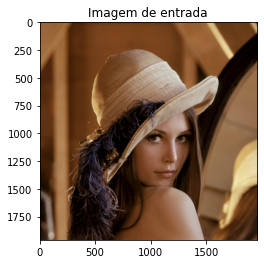

Dimensões da image: 1960(height) x 1960(width) x 3(depth)


In [2]:
# Lendo via imput (aparece uma caixinha para inserir o nome do arquivo embaixo dessa célula).
# Caso seja mais conveniente, basta comentar esse primeiro comando, e passar diretamente no segundo.

path_and_name = input('Insira o path e nome do arquivo: ')

img_input = cv2.imread(path_and_name)

img = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title('Imagem de entrada'),
plt.show()

[height , width, depth] = img.shape

h = np.float32(height) 
w = np.float32(width) 

print(f"Dimensões da image: {height}(height) x {width}(width) x {depth}(depth)")

O tamanho dos blocos em que vamos dividir a imagem para a compressão serão de 8x8 pixels. Dessa forma, existe a possibilidade que a imagem original não tenha dimensões múltiplas de 8, sendo necessário nesses casos completar a imagem (padding).

Abaixo, calculamos o teto da razão da altura e largura com o tamanho do bloco, criamos uma matriz de 0 com essas novas dimensões e colocamos a nossa imagem nela (a entrada 0,0,0 da original é a 0,0,0 da nova matriz). Caso a imagem tenha altura e largura múltiplas de 8, nada será alterado.

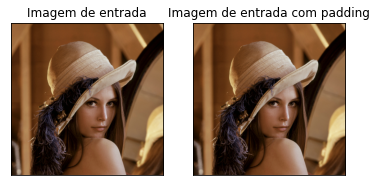

In [3]:
block_size = 8

nbh = math.ceil(h/block_size)
nbh = np.int32(nbh)

nbw = math.ceil(w/block_size)
nbw = np.int32(nbw)

H =  block_size * nbh
W =  block_size * nbw

padded_img = np.zeros((H, W, depth))
padded_img[0:height,0:width, 0:depth] = img[0:height,0:width,0:depth]

plt.subplot(121),plt.imshow(img)
plt.title('Imagem de entrada')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(padded_img.astype(np.uint8))
plt.title('Imagem de entrada com padding')
plt.xticks([]), plt.yticks([])
plt.show()

Agora vamos mudar a imagem para o espaço de cores YCrCb. Essa mudança do espaço é interessante para separar informações de luminosidade das de cores, permitindo quantizações diferentes (uma vez que o ser humano é mais sensível a mudanças de brilho do que de cor) e, assim, melhores compressões.

Vamos também salvar a imagem original (a com padding, já que ela é nosso ponto de partida), para comparar depois.

e realizar um deslocamento de nível de -128 em todos os valores das três bandas. O deslocamento por sua vez é importante por conta dos processos da DCT.

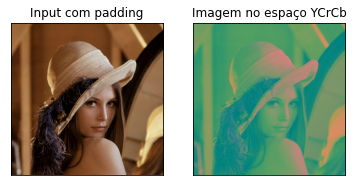

In [4]:
cv2.imwrite('uncompressed.bmp', cv2.cvtColor(padded_img.astype(np.uint8), cv2.COLOR_BGR2RGB))

plt.subplot(121)
plt.imshow(padded_img.astype(np.uint8))
plt.xticks([]), plt.yticks([])
plt.title('Input com padding')

padded_img = np.float32(cv2.cvtColor(padded_img.astype(np.uint8), cv2.COLOR_RGB2YCR_CB))
plt.subplot(122)
plt.imshow(padded_img.astype(np.uint8))
plt.xticks([]), plt.yticks([])
plt.title('Imagem no espaço YCrCb')
plt.show()


### Etapa de Compressão

Antes de começar a compressão, precisamos definir algumas coisas. As primeiras são as tabelas de quantização, que seguem abaixo. São essas tabelas que vão eliminar os coeficientes que tem pouca contribuição na qualidade da imagem, zerando muitos coeficientes do bloco depois da transformada. Quanto mais altos os valores, mais coeficientes serão eliminados, resultando em uma maior compressão e maior quantidade de informação perdida.

Perceba que a matriz de luminância (QTY, que aplicaremos a banda Y) tem valores menores, comparados com a das cores (QTC, que será aplicada nas bandas Cb e Cr). Isso ocorre por conta do fato já citado, que o ser humano é mais sensível a mudanças de brilho do que de cor, nos permitindo ser mais agressivos na quantização das cores, o que é refletido na tabela QTC.

In [5]:
# Tabela de quantização de luminância
QTY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

# Tabela de quantização de cor
QTC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])


Outras duas funções interessantes são as de zig-zag e zig-zag inverso. A primeira percorre o bloco em forma de zig-zag, partindo do 0,0 e indo até o 8,8. retornando a sequência de bits. Ela é interessante porque a grande maioria dos coeficientes zerados após a transformada estão na região da inversa diagonal inferior, de forma que andando em zig-zag, teremos uma grande sequência de 0's no final, o que permite uma fácil codificação.

A inversa por sua vez faz o contrário, recebe uma sequência de bits provindos de zig-zag, e gera o bloco em que foi gerado essa sequência. 

In [6]:
def zigzag(input):
    h = 0
    v = 0
    vmin = 0
    hmin = 0
    vmax = input.shape[0]
    hmax = input.shape[1]
    i = 0
    output = np.zeros((vmax * hmax))
    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:
            if (v == vmin):
                output[i] = input[v, h]

                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        
                i = i + 1
            elif ((h == hmax -1) and (v < vmax)):
                output[i] = input[v, h] 
                v = v + 1
                i = i + 1
            elif ((v > vmin) and (h < hmax -1 )):
                output[i] = input[v, h] 
                v = v - 1
                h = h + 1
                i = i + 1
        else:

            if ((v == vmax -1) and (h <= hmax -1)):
                output[i] = input[v, h] 
                h = h + 1
                i = i + 1
        
            elif (h == hmin):
                output[i] = input[v, h] 
                if (v == vmax -1):
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif ((v < vmax -1) and (h > hmin)):
                output[i] = input[v, h] 
                v = v + 1
                h = h - 1
                i = i + 1
        if ((v == vmax-1) and (h == hmax-1)):
            output[i] = input[v, h] 
            break
    return output



def inverse_zigzag(input, vmax, hmax):
    h = 0
    v = 0

    vmin = 0
    hmin = 0

    output = np.zeros((vmax, hmax))

    i = 0

    while ((v < vmax) and (h < hmax)): 
        if ((h + v) % 2) == 0:
            
            if (v == vmin):
                output[v, h] = input[i]

                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        

                i = i + 1

            elif ((h == hmax -1 ) and (v < vmax)):
                output[v, h] = input[i] 
                v = v + 1
                i = i + 1

            elif ((v > vmin) and (h < hmax -1 )):
                output[v, h] = input[i] 
                v = v - 1
                h = h + 1
                i = i + 1        
        else:
            if ((v == vmax -1) and (h <= hmax -1)):
                output[v, h] = input[i] 
                h = h + 1
                i = i + 1
            elif (h == hmin):
                output[v, h] = input[i] 
                if (v == vmax -1):
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif((v < vmax -1) and (h > hmin)):
                output[v, h] = input[i] 
                v = v + 1
                h = h - 1
                i = i + 1
        if ((v == vmax-1) and (h == hmax-1)):
            output[v, h] = input[i] 
            break
    return output




A última função que vamos precisar é a "join_zeros_encoding", que faz a codificação do bloco quantizado. Ela recebe uma imagem serializada e, para cada valor diferente de 0, ela concatena esse valor com o número de 0's que se foram encontrados entre o último não 0 e o valor atual. Apesar de parecer um pouco contra-intuitívo, uma vez que para cada valor escrevemos 2, os resultados contém tantos 0's que é comum ter uma sequência com 20, 21 0's, o que faz com que na prática tenhamos bastante ganho com essa codificação.

In [7]:
def join_zeros_encoding(image):
    i = 0
    skip = 0
    stream = []    
    bitstream = ""
    image = image.astype(int)
    while i < image.shape[0]:
        if image[i] != 0:            
            stream.append((image[i],skip))
            bitstream = bitstream + str(image[i])+ " " + str(skip)+ " "
            skip = 0
        else:
            skip = skip + 1
        i = i + 1

    return bitstream


Após realizar a compressão. Vamos interar por cada bloco em cada uma das três bandas, e realizar os seguintes procedimentos:

1. Realizar o deslocamento de nível de -128 em cada valor do bloco. Essa operação é interessante por deslocar os valores no intervalo [0,255] para [-128,127], que é centralizado em 0. Isso facilita as operações da transformada, pois reduz os requisitos de faixa dinâmica no estágio de processamento DCT.
2. Aplicar a transformada DCT no bloco.
3. Caso seja a banda de luminância, aplicar a tabela de quantização QTY. Senão, a QTC. Essa aplicação da tabela consiste em dividir os valores do bloco pela tabela, e arredondar.
4. Chamar a função de 'zig-zag' para o bloco quantizado;
5. Re-escrever o bloco com os valores resultantes do caminhamento em zig-zag, de forma que ao serializarmos a imagem tenhamos os caminhamentos em zig-zag em sequência.

Após esse processo, teremos na imagem os blocos codificados, e ao chamarmos a imagem.flattern() temos as sequências de zig-zag encontradas. Com isso, chamamos nossa função de codificação. Ao final, temos nossa imagem comprimida, e salvamos num arquivo .txt as coordenadas da imagem original, e em seguida a nossa sequência codificada, encerrando o processo.

Para demonstrar o processo, estamos printando algumas saídas de uma interação (123,123,0), bem como o começo do antes e depois da codificação.

In [8]:
for i in range(nbh):    
        row_ind_1 = i*block_size                
        row_ind_2 = row_ind_1+block_size
        
        for j in range(nbw):
            col_ind_1 = j*block_size                       
            col_ind_2 = col_ind_1+block_size
    
            for d in range(depth):
                block = padded_img[ row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2, d ]-np.ones((8,8))*128
                DCT = cv2.dct(block)
                if(d == 0):
                    DCT_normalized = np.divide(DCT,QTY).astype(int)               
                else:
                    DCT_normalized = np.divide(DCT,QTC).astype(int)            
                reordered = zigzag(DCT_normalized)
                reshaped= np.reshape(reordered, (block_size, block_size)) 
                padded_img[row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2, d] = reshaped
                
                # talvez tenha que alterar caso imagem seja muito pequena
                # valores aleatórios
                if(i==33 and j==33 and d==0):
                    print(f"\nBloco {i},{j},{d} shiftado (-128):")
                    print(block)
                    print("\nBloco após DCT:")
                    print(DCT)
                    print("\nBloco normalizado:")
                    print(DCT_normalized)
                    print("\nZig-zag do bloco:")
                    print(reordered)
                    print("\nBloco re-arranjado com base no zig-zag:")
                    print(reshaped)
                    
arranged = padded_img.flatten()
print("\n\nImagem serializada (decodificada):\n", arranged[:70])

bitstream = join_zeros_encoding(arranged)
print("\nImagem codificada (sem coordenadas):\n", bitstream[:70])

bitstream = str(padded_img.shape[0]) + " " + str(padded_img.shape[1]) + " " + str(depth) + " " + bitstream + ";"
print("\nImagem codificada (sem coordenadas):\n", bitstream[:70])

file1 = open("image_compressed.txt","w")

file1.write(bitstream)

file1.close()

# uma maneira de calcular a taxa é dividir o tamanho da imagem.flatten() pelo tamanho da string codificada
# usar caso não tenha permissão para acessar os arquivos do diretório 
# ratio_aux = arranged.shape[0]/(len(bitstream))


Bloco 33,33,0 shiftado (-128):
[[-80. -76. -75. -79. -82. -83. -84. -86.]
 [-80. -77. -76. -78. -81. -84. -85. -86.]
 [-83. -82. -80. -79. -80. -83. -84. -83.]
 [-81. -83. -82. -80. -81. -84. -84. -82.]
 [-77. -80. -81. -81. -83. -87. -87. -84.]
 [-79. -81. -82. -82. -83. -84. -84. -83.]
 [-83. -82. -82. -83. -82. -81. -81. -83.]
 [-81. -79. -79. -82. -82. -81. -84. -88.]]

Bloco após DCT:
[[-6.54250000e+02  1.35164966e+01 -4.03857340e+00 -2.76508510e+00
   0.00000000e+00 -1.72504223e-01  4.92435726e-02  5.03852094e-01]
 [ 3.87333404e+00  4.08087162e+00 -2.97596519e+00 -4.36257942e+00
   4.32861459e-01 -1.44196184e-01 -3.41168608e-01  6.46329979e-02]
 [ 3.15432203e+00  2.80258521e+00 -3.14276695e+00  2.15959295e-01
  -7.28856628e+00 -4.44971831e-01 -5.17766953e-02  5.79088415e-02]
 [ 2.83799197e-01  3.07087945e+00  3.77578888e+00 -5.66552416e-01
   1.76221475e-01  1.80901906e-01 -1.28859997e-01 -7.19178157e-02]
 [-2.50000000e-01  3.88828590e+00  4.22311599e-01  6.97385280e-02
   0.000

### Etapa de descompressão

Na etapa de descompressão, começamos lendo a imagem comprimida, pegando as dimensões da imagem. Em seguida, criamos um array com o produto dessas dimensões e lemos o arquivo, tratando os valores (já que lemos como string e precisamos como números), e decodificando: como criamos um vetor de 0's para escrever a imagem, quando encontramos uma sequência de 0's de tamanho X, basta pular X casas e continuar escrevendo.

Em seguida, criamos uma matriz com as dimensões da imagem e fazemos o processs inverso da compressão, fazendo o zig-zag inverso, desquantizando de acordo com a banda, alicando a inversa da DCT e shiftando os valores para +128, para colocar de volta no range [0,255].

In [9]:
with open('image_compressed.txt', 'r') as myfile:
    image=myfile.read()

details = image.split()

h = int(''.join(filter(str.isdigit, details[0])))
w = int(''.join(filter(str.isdigit, details[1])))
d = int(''.join(filter(str.isdigit, details[2])))

print("Dimensões da imagem original: ", h, w, d)

array = np.zeros(h*w*d).astype(int)

k = 0
i = 3
x = 0
j = 0

while k < array.shape[0]:
    if(details[i] == ';'):
        break
    if "-" not in details[i]:
        array[k] = int(''.join(filter(str.isdigit, details[i])))        
    else:
        array[k] = -1*int(''.join(filter(str.isdigit, details[i])))        

    if(i+3 < len(details)):
        j = int(''.join(filter(str.isdigit, details[i+3])))

    if j == 0:
        k = k + 1
    else:                
        k = k + j + 1        

    i = i + 2

print("\nImagem decodifica após ser lida do arquivo:\n", array[:70])
array = np.reshape(array,(h,w,d))

i = 0
j = 0

padded_img = np.zeros((h,w,d))

while i < h:
    j = 0
    while j < w:
        for t in range(d):
            temp_stream = array[i:i+8,j:j+8, t]                
            block = inverse_zigzag(temp_stream.flatten(), int(block_size),int(block_size))            
            if(d == 0):
                de_quantized = np.multiply(block,QTY)                
            else:
                de_quantized = np.multiply(block,QTC)
            padded_img[i:i+8,j:j+8, t] = cv2.idct(de_quantized)
            padded_img[i:i+8,j:j+8, t] = padded_img[i:i+8,j:j+8, t] + np.ones((8,8))*128
            
            # talvez tenha que alterar caso imagem seja muito pequena
            # valores aleatórios
            if(i==40 and j==40 and t==0):
                print(f"\nBloco {i},{j},{t} original (decodificado):")
                print(temp_stream)
                print("\nBloco após zig-zag inverso:")
                print(block)
                print("\nBloco dequantizado:")
                print(de_quantized)
                print("\nBloco após DCT inversa e shiftado (+128):")
                print(padded_img[i:i+8,j:j+8, t])
        j = j + 8        
    i = i + 8


Dimensões da imagem original:  1960 1960 3

Imagem decodifica após ser lida do arquivo:
 [ -6  14 -15   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  -7  14 -15   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0  -7  14 -14   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]

Bloco 40,40,0 original (decodificado):
[[-7  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]

Bloco após zig-zag inverso:
[[-7.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

Bloco dequantizado:
[[-119.    0.    0.    0.    0.    0. 

O processo de deslocamento de nível de +128 des processo pode levar a gerar valores maiores que 255 e/ou menores que 0, e nesse caso setamos para 255 e 0, respectivamente.

Como passamos a imagem para o espaço de cores YCrCb na compressão, precisamos voltá-la para o RGB, e com isso, finalizamos a descompressão. Salvamos a imagem resultante.

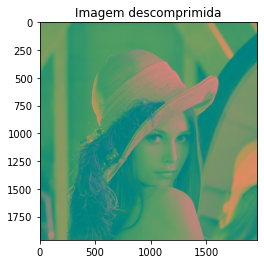

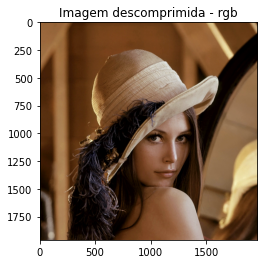

True

In [10]:
padded_img[padded_img > 255] = 255
padded_img[padded_img < 0] = 0

plt.imshow(padded_img.astype(np.uint8))
plt.title('Imagem descomprimida'),
plt.show()

padded_img = cv2.cvtColor(padded_img.astype(np.uint8), cv2.COLOR_YCR_CB2RGB)
plt.imshow(padded_img)
plt.title('Imagem descomprimida - rgb'),
plt.show()

cv2.imwrite("decompressed.bmp",cv2.cvtColor(padded_img.astype(np.uint8), cv2.COLOR_BGR2RGB))

Abaixo, calculamos o PSNR a partir da imagem original e da decomprimida, e a taxa de compressão a partir da razão entre o tamanho da imagem originial e da imagem comprimida. Plotamos também as duas imagens, do começo e do final do processo.

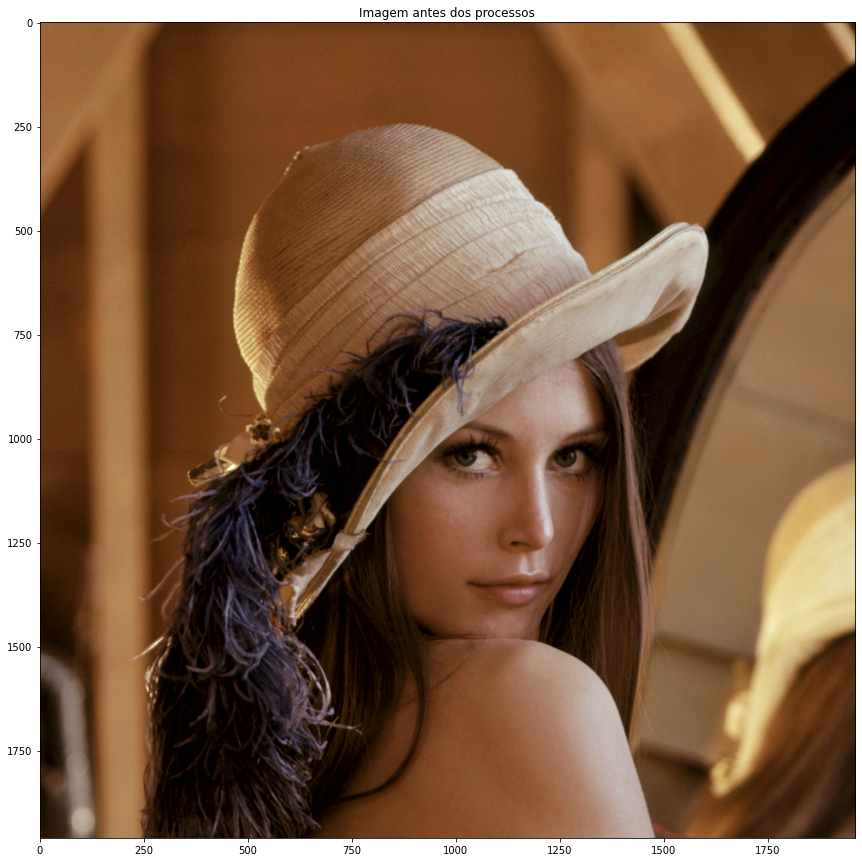

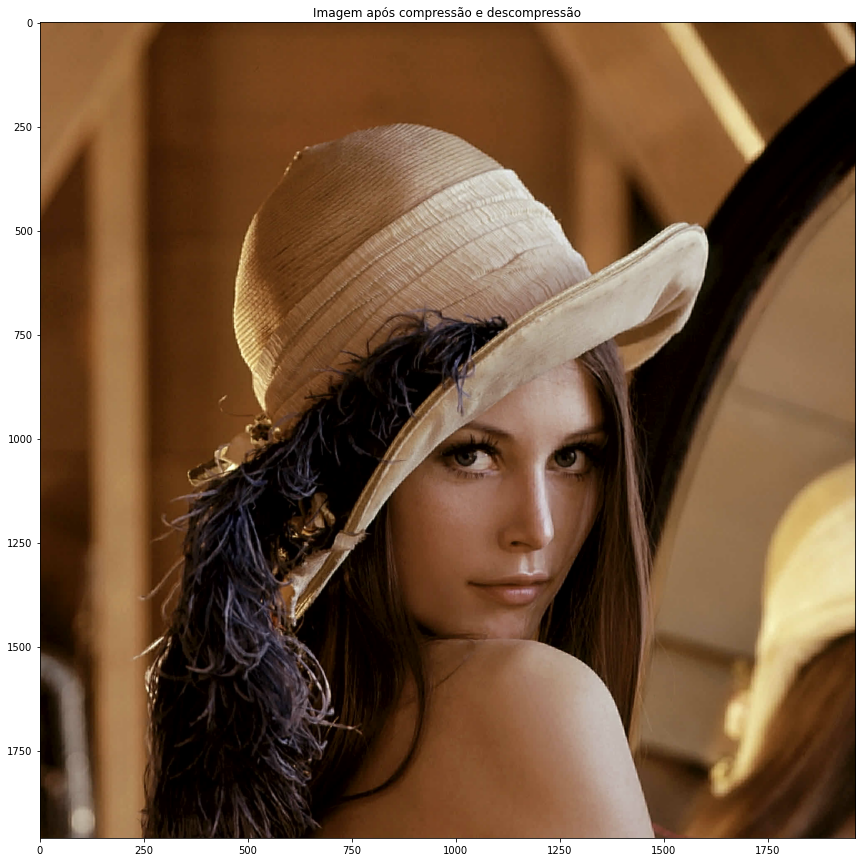

PSNR: 34.30479576301755 dB
Taxa de Compressão: 8.605241759956634


In [11]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

uncompressed = cv2.imread("./uncompressed.bmp")
decompressed = cv2.imread("./decompressed.bmp")

plt.figure(figsize = (15,15))
plt.imshow(cv2.cvtColor(uncompressed, cv2.COLOR_BGR2RGB))
plt.title('Imagem antes dos processos'),
plt.show()

plt.figure(figsize = (15,15))
plt.imshow(cv2.cvtColor(decompressed, cv2.COLOR_BGR2RGB))
plt.title('Imagem após compressão e descompressão'),
plt.show()

uncompressed = uncompressed.flatten()
decompressed = decompressed.flatten()

value = PSNR(uncompressed, decompressed)

ratio = os.path.getsize("uncompressed.bmp")/os.path.getsize("image_compressed.txt")
print(f"PSNR: {value} dB")
print(f"Taxa de Compressão: {ratio}")

De acordo com a literatura, valores de PSNR entre 30dB e 50dB (para imagem com 8-bits de profundidade) são típicos, o que nosso algoritmo consegue alcançar (para as imagens que testamos, obtemos PSNR por volta de 30). 

Já as taxas de compressão para o JPEG para imagens coloridas costumam estar entre 10:1 e 20:1 para sem grandes perdas na imagem (usualmente com as tabelas de quantização que usamos). Nos nossos testes obtivemos uma taxa média por volta de 8.5, e atribuimos isso ao fato da nossa codificação. Optamos por usar uma mais simples (que não faça usa da redundância de codificação, como Huffman ou aritmética, que são comuns no JPEG padrão), para avaliar o quanto a redundância psicovisual, aliada a interpixel por conta do funcionamento do JPEG, é relevante na compressão. Percebemos que é o principal componente, computando informações que podem ser descartadas sem mudanças relevantes na imagem, sendo inclusive ela que possibilita (nesse algoritmo) as outras redundâncias performarem bem.